# Subnetwork PCMCI+ example

## Setup

In [1]:
import glob
import os
import subprocess
import pickle as cPickle
import ast
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import pickle
## use `%matplotlib notebook` for interactive figures
# plt.style.use('ggplot')
import numpy as np
import sklearn
import tigramite
from tigramite import data_processing as pp
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests.parcorr import ParCorr
import pandas as pd
import seaborn as sns


In [2]:
#path depending on timebin
pca_res_path="./c-transfer"
pcmci_res_path="./output"
f1_scores_path="./output_f1-scores/subnetwork"
model_names=['ACCESS-CM2', 'BCC-CSM2-MR', 'CanESM5', 'CESM2', 'CNRM-CM6-1', 'EC-Earth3', 'HadGEM3-GC31-LL', 'IPSL-CM6A-LR', 'MIROC-ES2L',
             'MPI-ESM1-2-HR', 'UKESM1-0-LL']


In [3]:
related_models=[]
related_models.append((0, 6, 10))
related_models.append((1,))
related_models.append((2,))
related_models.append((3,))
related_models.append((4,))
related_models.append((5,))
related_models.append((0, 6, 10))
related_models.append((7,))
related_models.append((8,))
related_models.append((9,))
related_models.append((0, 6, 10))

In [4]:
f1Scores={}
f1ScoresLinks={}
links={}
for file in os.listdir(f1_scores_path):
    f1_scores_single_path=os.path.join(f1_scores_path, file)
    f1_scores_single=pickle.load(open(f1_scores_single_path,"rb"))
    pc_alpha=f1_scores_single['pc_alpha']
    n_kept_comp=f1_scores_single['n_kept_comp']
    if 'selected_comps' in f1_scores_single.keys():
        selected_comps=f1_scores_single['selected_comps']
    else:
        selected_comps=f1_scores_single['selected_komps']        
    treshold=f1_scores_single['treshold']
    links[treshold]=f1_scores_single['links']
    f1Scores[(pc_alpha, n_kept_comp, str(selected_comps), treshold)]=f1_scores_single['f1Scores']  
    f1ScoresLinks[(pc_alpha, n_kept_comp, str(selected_comps), treshold)]=(f1_scores_single['f1Scores'], f1_scores_single['links'])

In [5]:
f1Scores_={} #f1Scores sortiert bzw. die einträge der keys sortiert nach alpha_value
for key in f1Scores:
    scores=f1Scores[key]
    tempList={}
    for element in scores:
        for key2 in element:
            tempList[key2]=element[key2]
    sorted_dict = dict(sorted(tempList.items()))
    f1Scores_[key]=sorted_dict
    

In [6]:
avg_f1_scores_models={} #avg F1-Score for each refModel F1-Matrix
for key in f1Scores_:
    scores=f1Scores_[key]
    avg_f1_scores_models.setdefault(key, {})
    for key2 in scores:
        avg_f1_scores_models[key][key2]=np.nanmean(scores[key2], axis=(2, 3)) #also avg f1 score für key1=pc_alpha und key2=refDataSet, avg F1-Score pro Model

In [7]:
#metric1 for all refDatasets. Returns average f1-score-metric1-distance for all refDatasets
def metric1(f1scores): #f14d matrix
    result=[]
    for i,refDataset in enumerate(f1scores):
        scores=f1scores[i]
        min_scores=[]
        max_scores=[]
        for element in scores:
            arr=np.array(element)
            min_scores.append(np.nanmin(arr))
            max_scores.append(np.nanmax(arr))
        result.append(np.mean(np.subtract(max_scores, min_scores)))
    return result

In [8]:
def metric2_(key, f1scores, relModelsTuple, refModelIndex, alphaValue):#f1scores for specific model for testing! not full matrix
    avgF1Distance = np.full((len(relModelsTuple), len(model_names)), np.nan)
    for i, modelIndex in enumerate(relModelsTuple):
        for j, model in enumerate(model_names):
            if j not in relModelsTuple:
                val=abs(avg_f1_scores_models[key][alphaValue][refModelIndex][modelIndex]-avg_f1_scores_models[key][alphaValue][refModelIndex][j])
                avgF1Distance[i][j]=val
                                        
    return avgF1Distance, np.nanmean(avgF1Distance)
        
    
    

In [9]:
def metric2(key, alphaValue):#f1scores for specific model for testing! not full matrix
    avgF1DistanceFinal=[]
    for refModelIndex, model in enumerate(model_names):
        relModelsTuple=related_models[refModelIndex]
        avgF1Distance = np.full((len(relModelsTuple), len(model_names)), np.nan)
        for i, modelIndex in enumerate(relModelsTuple):
            for j, model in enumerate(model_names):
                if j not in relModelsTuple:
                    val=abs(avg_f1_scores_models[key][alphaValue][refModelIndex][modelIndex]-avg_f1_scores_models[key][alphaValue][refModelIndex][j])
                    avgF1Distance[i][j]=val
        avgF1DistanceFinal.append(np.nanmean(avgF1Distance))
    #print(key, np.nanmean(np.array(avgF1DistanceFinal)))
    return None, np.nanmean(np.array(avgF1DistanceFinal))
        
    
    

In [10]:
def plot_metric2_div_metric1(key):
    # Gleichmäßig verteilte x-Werte erstellen
    values=metric2_div_metric1[key]
    x_values, y_values = zip(*values)
    x_values=list(x_values)
    y_values=list(y_values)
    x_uniform = np.linspace(min(x_values), max(x_values), len(x_values))
    labels=x_values

    # Plot erstellen
    plt.plot(x_uniform, y_values, marker='o', linestyle='-')

    # Labels hinzufügen
    for i, txt in enumerate(labels):
        plt.annotate(txt, (x_uniform[i], y_values[i]), textcoords="offset points", xytext=(0,10), ha='center')
        
    plotTitle='Nr. of components: ' + str(key[1]) + ', pc_alpha: ' + str(key[0]) + ', hash of selected_comps: ' + str(hash(str(key[2])))
    plt.title(plotTitle)
    plt.ylabel('F1-Score')
    plt.figtext(0, 0, 'The resulting F1-Scores for N components, specific pc_alpha (see title) and different alpha_values vizualized')

    plt.ylim(0, 2)
    
    # Plot anzeigen
    plt.show()

In [11]:
metric1Mins={} #Mins for the metric1 mean values per (alphaValue, n_kept_comp)
for key in f1Scores_:
    metric1values=[]
    f1_score_single=f1Scores_[key]
    for key2 in f1_score_single:
        metric1values.append(   (key2, np.mean((metric1(f1_score_single[key2]))))   )
    metric1Mins[key]=min(metric1values, key = lambda t: t[1])

        


In [12]:
metric2Maxs={}
for key in f1Scores_:
    metric2values=[]
    f1_score_single=f1Scores_[key]
    for key2 in f1_score_single:
        #metric2values.append((key2, metric2_(key, None, related_models[0], 6, key2)[1]))
        metric2values.append((key2, metric2(key, key2)[1]))

    metric2Maxs[key]=max(metric2values, key = lambda t: t[1])

In [13]:
metric2_div_metric1_maxs={}
metric2_div_metric1={}
for key in f1Scores_:
    metric2divmetric1values=[]
    f1_score_single=f1Scores_[key]
    metric2_div_metric1.setdefault(key, [])
    for key2 in f1_score_single:
        m1=np.mean(metric1(f1_score_single[key2]))
        #m2=metric2_(key, None, related_models[0], 6, key2)[1]
        m2=metric2(key, key2)[1]
        metric2divmetric1values.append((key2, m2/m1, m2, m1))
        metric2_div_metric1[key].append((key2, m2/m1))
    metric2_div_metric1_maxs[key]=max(metric2divmetric1values, key = lambda t: t[1])

In [14]:
metric2_div_metric1_maxs_2={} #(comps, pc_alpha, alpha_value): F1-Score  wobei alpha_value für den max erreichten F1-Score gegeben ist
for key in metric2_div_metric1_maxs:
    pc_alpha=key[0]
    comps=key[1]
    sel_comps=key[2]
    alpha_value=metric2_div_metric1_maxs[key][0]
    metric2_div_metric1_maxs_2[(comps,pc_alpha,alpha_value,sel_comps)]=metric2_div_metric1_maxs[key][1]

In [15]:
sorted_dict_komps = dict(sorted(metric2_div_metric1_maxs.items(), key=lambda x: x[0][0])) #sortiert nach comps, dann pc_alpha

In [16]:
sorted_dict_komps

{(0.02, 50, 'range(0, 50)', (0, 0)): (0.0001,
  2.6572420636018856,
  0.6148989898192361,
  0.23140495863810837),
 (0.02, 50, 'range(0, 50)', (0, 1)): (0.0001,
  1.8452623560889798,
  0.592321228116136,
  0.32099567097415704),
 (0.02, 50, 'range(0, 50)', (0, 10)): (0.0001,
  2.3561897358060224,
  0.3449399033734814,
  0.1463973372481745),
 (0.02, 50, 'range(0, 50)', (0, 11)): (0.0001,
  2.5922802803028357,
  0.33429798033138697,
  0.1289590415324741),
 (0.02, 50, 'range(0, 50)', (0, 12)): (0.0001,
  2.66796594703659,
  0.3219314969194229,
  0.12066551946699482),
 (0.02, 50, 'range(0, 50)', (0, 13)): (0.0001,
  2.644538187938567,
  0.3047456593328393,
  0.11523587018812925),
 (0.02, 50, 'range(0, 50)', (0, 14)): (0.0001,
  2.7773086500630533,
  0.2971476214618084,
  0.1069912130418282),
 (0.02, 50, 'range(0, 50)', (0, 15)): (0.0001,
  2.7576431987758183,
  0.28808722053875385,
  0.1044686349077511),
 (0.02, 50, 'range(0, 50)', (0, 16)): (0.0001,
  2.775226968868222,
  0.2821841285540982

## Visualizations

In [17]:
toPlot=[]
for key in metric2_div_metric1_maxs:
    under,upper=key[3]
    metricScore=metric2_div_metric1_maxs[key][1]
    toPlot.append((under, upper, metricScore))

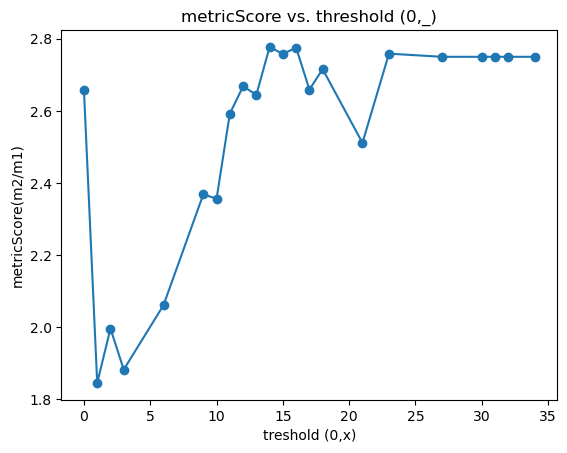

In [18]:
filtered_data0 = [(tup[1], tup[2]) for tup in toPlot if tup[0] == 0]
filtered_data0 = sorted(filtered_data0, key=lambda x: x[0])
x_values, y_values = zip(*filtered_data0)

# Plot erstellen
plt.plot(x_values, y_values, marker='o', linestyle='-')
plt.xlabel('treshold (0,x)')
plt.ylabel('metricScore(m2/m1)')
plt.title('metricScore vs. threshold (0,_)')
plt.show()                   

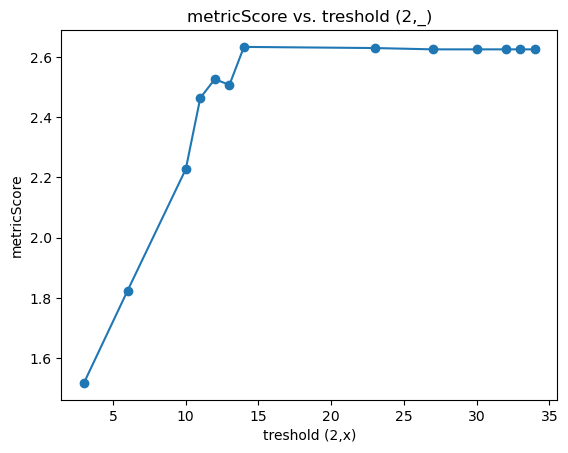

In [19]:
filtered_data2 = [(tup[1], tup[2]) for tup in toPlot if tup[0] == 2]
filtered_data2 = sorted(filtered_data2, key=lambda x: x[0])
x_values, y_values = zip(*filtered_data2)

# Plot erstellen
plt.plot(x_values, y_values, marker='o', linestyle='-')
plt.xlabel('treshold (2,x)')
plt.ylabel('metricScore')
plt.title('metricScore vs. treshold (2,_)')
plt.show()

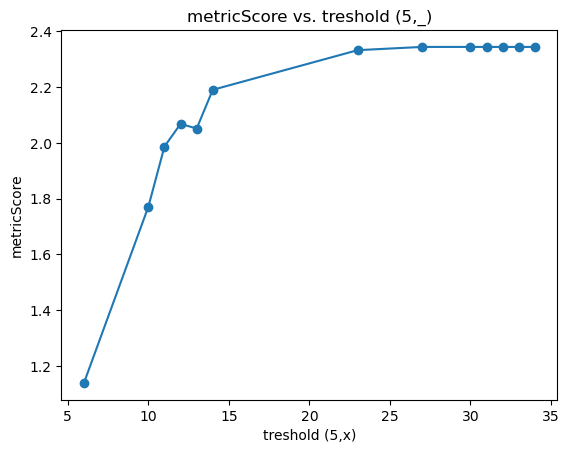

In [20]:
filtered_data5 = [(tup[1], tup[2]) for tup in toPlot if tup[0] == 5]
filtered_data5 = sorted(filtered_data5, key=lambda x: x[0])
x_values, y_values = zip(*filtered_data5)

# Plot erstellen
plt.plot(x_values, y_values, marker='o', linestyle='-')
plt.xlabel('treshold (5,x)')
plt.ylabel('metricScore')
plt.title('metricScore vs. treshold (5,_)')
plt.show()

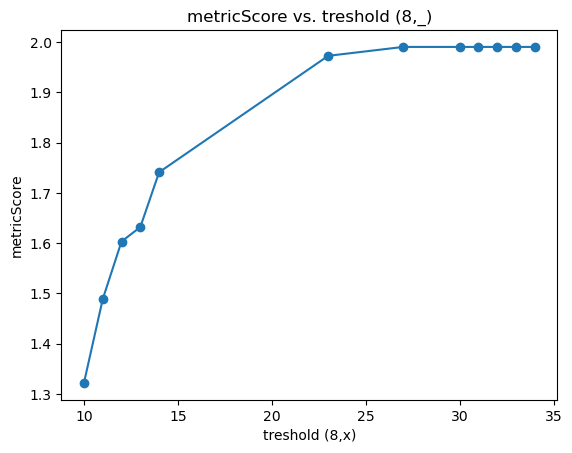

In [21]:
filtered_data8 = [(tup[1], tup[2]) for tup in toPlot if tup[0] == 8]
filtered_data8 = sorted(filtered_data8, key=lambda x: x[0])
x_values, y_values = zip(*filtered_data8)

# Plot erstellen
plt.plot(x_values, y_values, marker='o', linestyle='-')
plt.xlabel('treshold (8,x)')
plt.ylabel('metricScore')
plt.title('metricScore vs. treshold (8,_)')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
data=toPlot
x1_values = [entry[0] for entry in data]
x2_values = [entry[1] for entry in data]
x3_values = [entry[2] for entry in data]

# Erstelle den 3D-Plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Punkte plotten
ax.scatter(x1_values, x2_values, x3_values, c='r', marker='o')

# Verbinde die Punkte durch Flächen
ax.plot_trisurf(x1_values, x2_values, x3_values, color='b', alpha=0.5)

# Beschriftungen der Achsen
ax.set_xlabel('underThreshold')
ax.set_ylabel('upperThreshold')
ax.set_zlabel('metric-score')

plt.show()